In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import torch 
import tensorflow as tf 
from tensorflow import keras 
import sklearn 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# Matplotlib global settings 

import matplotlib as mpl 

mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['axes.labelsize'] = 16 
mpl.rcParams['axes.titlesize'] = 20 

In [3]:
train_path = '/kaggle/input/asl-signs/train.csv'
sign2pred = '/kaggle/input/asl-signs/sign_to_prediction_index_map.json'

train_csv = pd.read_csv(train_path)
# sign2index = pd.read_json(sign2pred)

print("Train shape : "  , train_csv.shape)
display(train_csv.head())
# display(sign2index)

Train shape :  (94477, 4)


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [4]:
train_csv.nunique()

path              94477
participant_id       21
sequence_id       94477
sign                250
dtype: int64

,participant_id,Contribution
0,2044,4810
1,4718,3499
2,16069,4848
3,18796,3502
4,22343,4677


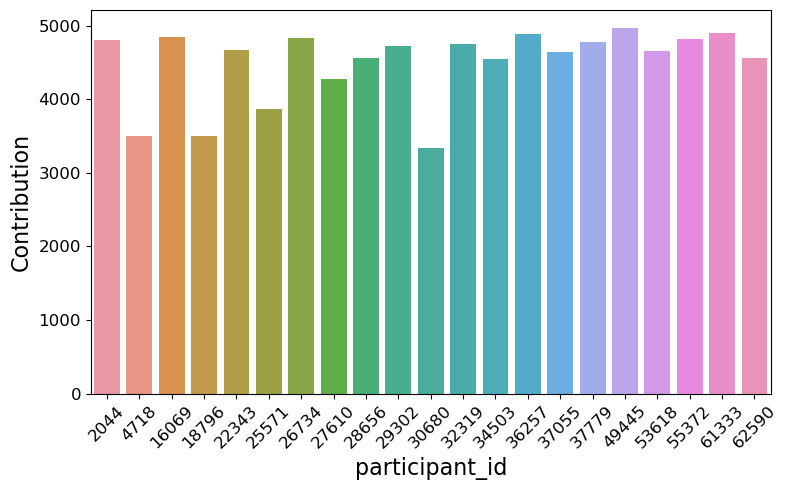

In [5]:
df_participant = train_csv.groupby(['participant_id'])['sign'].count().reset_index().rename(columns = {'sign' : 'Contribution'})
display(df_participant.head())

plt.figure(figsize = (8,5))
sns.barplot(data = df_participant , x = 'participant_id' , y = 'Contribution')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

All participants have almost equal contributions Therefore , Chances of biasing are low.

,sign,Sign_Count
0,TV,385
1,after,347
2,airplane,393
3,all,386
4,alligator,390


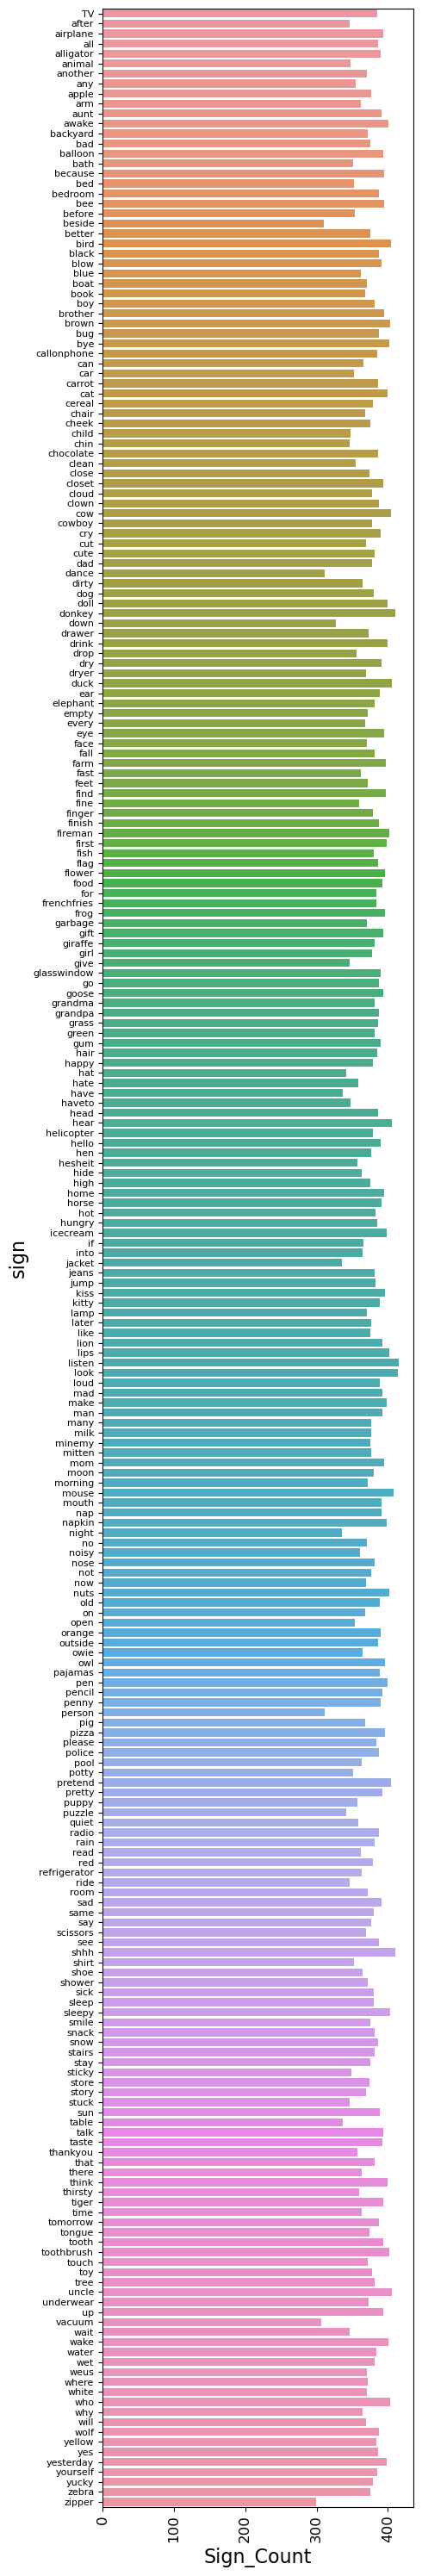

In [6]:
df_sign = train_csv.groupby(['sign'])['sequence_id'].count().reset_index().rename(columns = {'sequence_id' : 'Sign_Count'})
display(df_sign.head())

mpl.rcParams['ytick.labelsize'] = 8
plt.figure(figsize = (5,30))
sns.barplot(data = df_sign , x = 'Sign_Count' , y = 'sign',orient = 'h')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

Good to see that all the above signs are present in equal count.

In [7]:
display(train_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


None

In [8]:
sign2pred = pd.read_json('/kaggle/input/asl-signs/sign_to_prediction_index_map.json',
                         orient = 'index' ).to_dict()


train_csv['path'] = '/kaggle/input/asl-signs/' + train_csv['path']
train_csv['sign_index'] = train_csv['sign'].apply(lambda x : sign2pred[0][x])

display(train_csv.head())

,path,participant_id,sequence_id,sign,sign_index
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,25
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,232
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud,48
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird,23
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie,164


In [9]:
example_df = pd.read_parquet('/kaggle/input/asl-signs/train_landmark_files/16069/100015657.parquet')
example_df.head()

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013


In [10]:
example_df.shape

(57015, 7)

In [11]:
df_type_notnull = example_df.groupby(['frame','type'])['x','y','z'].apply(lambda x : x.isnull().sum())
df_type_notnull

x   y   z
frame type                  
103   face         0   0   0
      left_hand    0   0   0
      pose         0   0   0
      right_hand  21  21  21
104   face         0   0   0
...               ..  ..  ..
206   right_hand  21  21  21
207   face         0   0   0
      left_hand    0   0   0
      pose         0   0   0
      right_hand  21  21  21

[420 rows x 3 columns]

In [12]:
from tqdm import tqdm

N = int(10e3) 

N_UNIQUE_FRAMES = np.zeros(N)
MAX_FRAME = np.zeros(N)

MIN_FRAME = np.zeros(N)
N_MISSING_FRAMES = np.zeros(N)

ct = 0
sample_files = train_csv['path'].sample(N , random_state = 42)
for idx , file_path in enumerate(tqdm(sample_files)):
    video_file = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = video_file['frame'].nunique()
    MAX_FRAME[idx] = video_file['frame'].max()
    MIN_FRAME[idx] = video_file['frame'].min()
    N_MISSING_FRAMES[idx] = MAX_FRAME[idx] - MIN_FRAME[idx] - N_UNIQUE_FRAMES[idx]+1

100%|██████████| 10000/10000 [04:09<00:00, 40.02it/s]


In [13]:
N_UNIQUE_FRAMES.mean()

37.7158

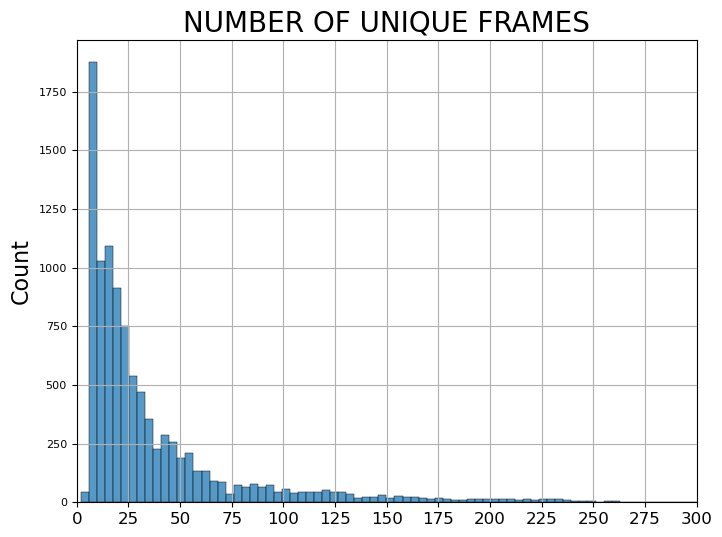

In [14]:
plt.figure(figsize = (8,6))
sns.histplot(x = N_UNIQUE_FRAMES , bins = 128)
plt.grid()
xlim = 300
plt.xlim(0,xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.title('NUMBER OF UNIQUE FRAMES')
plt.show()

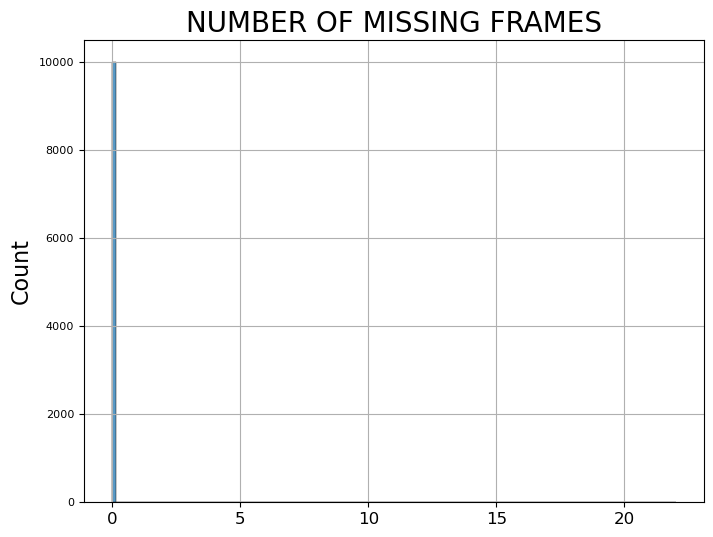

In [15]:
plt.figure(figsize = (8,6))
sns.histplot(x = N_MISSING_FRAMES , bins = 128)
plt.grid()
# xlim = 
# plt.xlim(0,xlim)
# plt.xticks(np.arange(0, xlim+25, 25))
plt.title('NUMBER OF MISSING FRAMES')
plt.show()

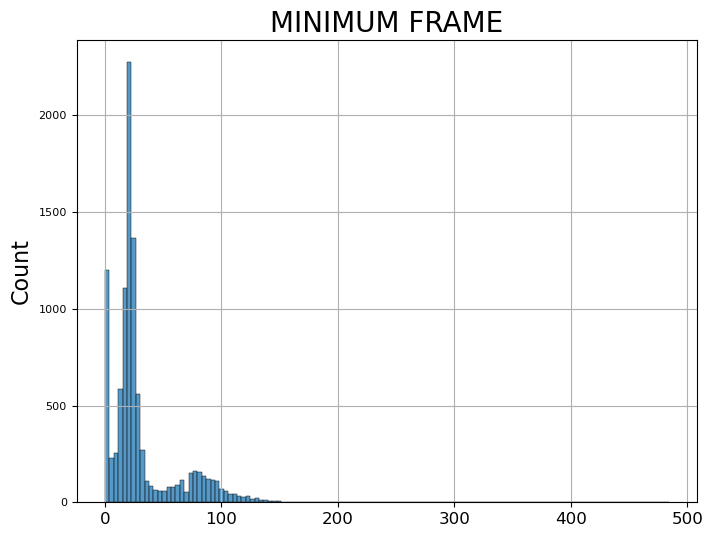

In [16]:
plt.figure(figsize = (8,6))
sns.histplot(x = MIN_FRAME , bins = 128)
plt.grid()
# xlim = 
# plt.xlim(0,xlim)
# plt.xticks(np.arange(0, xlim+25, 25))
plt.title('MINIMUM FRAME')
plt.show()

In [17]:
indexes = {'face' : [] , 'left_hand':[] , 'right_hand' : [] , 'pose' : []}

for idx , frame in enumerate(example_df['frame'].unique()):
    df = example_df[example_df['frame'] == frame]
    for type in ['face' , 'left_hand' , 'right_hand' , 'pose']:
                     indexes[type].append(df[df['type'] == type].index[0])

In [18]:
pd.DataFrame(indexes).head()

,face,left_hand,right_hand,pose
0,0,468,522,489
1,543,1011,1065,1032
2,1086,1554,1608,1575
3,1629,2097,2151,2118
4,2172,2640,2694,2661


In [19]:
USETYPES = ['left_hand' , 'pose' , 'right_hand'] 
LEFT_HAND_IDX = np.arange(468 , 489)
RIGHT_HAND_IDX = np.arange(522 , 543)
LEFTHAND_POSE_IDX = np.array([502,504,506,508,510])
RIGHTHAND_POSE_IDX = np.array([503,505,507,509,511])

LIPS_IDX = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

LEFTHAND_DOMINANT_IDX = np.concatenate([LIPS_IDX , LEFT_HAND_IDX , LEFTHAND_POSE_IDX])
RIGHTHAND_DOMINANT_IDX = np.concatenate([LIPS_IDX , RIGHT_HAND_IDX , RIGHTHAND_POSE_IDX])

LIPS_IND = np.argwhere(np.isin(LEFTHAND_DOMINANT_IDX , LIPS_IDX)).squeeze()
LEFTHAND_IND = np.argwhere(np.isin(LEFTHAND_DOMINANT_IDX , LEFT_HAND_IDX)).squeeze()
LEFTHAND_POSE_IND = np.argwhere(np.isin(LEFTHAND_DOMINANT_IDX , LEFTHAND_POSE_IDX)).squeeze()

print(LIPS_IND)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [20]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IND.size
POSE_START = LEFT_HAND_START + LEFTHAND_IND.size
# POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, POSE_START: 61


# Data Preprocessing

In [21]:
a = tf.constant([len(LIPS_IND)*[0] + len(LEFTHAND_IND)*[0.5] + len(LEFTHAND_POSE_IND)*[0.5],
            [0]*LEFTHAND_DOMINANT_IDX,
            [0]*LEFTHAND_DOMINANT_IDX,],
            dtype = tf.float32)
b = tf.transpose(a,[1,0])
b

<tf.Tensor: shape=(66, 3), dtype=float32, numpy=
array([[0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0.

In [22]:
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
NUM_CLASSES = 250
INPUT_SIZE = 36
N_COLS = LEFTHAND_DOMINANT_IDX.shape[0]

print(N_COLS)

66


In [23]:
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [24]:
class PreProcessing(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        normalisation_correction = tf.constant([
                    [0] * len(LIPS_IDX) + [0.50] * len(LEFT_HAND_IDX) + [0.50] * len(LEFTHAND_POSE_IDX),
                    [0] * len(LEFTHAND_DOMINANT_IDX),
                    [0] * len(LEFTHAND_DOMINANT_IDX),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
    
    def pad_edge(self , t , repeats , side):
        if(side == 'LEFT'):
            t = tf.concat((tf.repeat(t[:1] , repeats = repeats ,axis = 0) , t),axis = 0)
            return t 
        elif(side == 'RIGHT'):
            t = tf.concat((t,tf.repeat(t[-1:] , repeats = repeats ,axis = 0)),axis = 0)
            return t   
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self , data):
        self.data = tf.shape(data)[0]

        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data , LEFT_HAND_IDX , axis = 1)),0,1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data , RIGHT_HAND_IDX , axis = 1)),0,1))

        left_dominant = left_hand_sum >= right_hand_sum
        
        if left_dominant:
            frames_non_nan_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data , LEFT_HAND_IDX , axis = 1)),0,1),
                                                    axis = [1,2])
        else:
            frames_non_nan_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data , RIGHT_HAND_IDX , axis = 1)),0,1),
                                                    axis = [1,2])
            
        non_empty_frame_indx = tf.where(frames_non_nan_sum > 0)
        non_empty_frame_indx = tf.squeeze(non_empty_frame_indx , axis = 1)
        
        data_non_empty = tf.gather(data , non_empty_frame_indx , axis = 0)
        
        N_FRAMES = tf.shape(data_non_empty)[0]
        
        if left_dominant:
            data_non_empty = tf.gather(data_non_empty , LEFTHAND_DOMINANT_IDX , axis = 1)
        else:
            data_non_empty = tf.gather(data_non_empty , RIGHTHAND_DOMINANT_IDX , axis = 1)
            data_non_empty = (
                    self.normalisation_correction + (
                        (data_non_empty - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        non_empty_frame_indx = tf.cast(non_empty_frame_indx, tf.float32)
        # Normalize to start with 0
        non_empty_frame_indx -= tf.reduce_min(non_empty_frame_indx)
        
        if(N_FRAMES < INPUT_SIZE):
            data = tf.pad(data_non_empty , [[0,INPUT_SIZE-N_FRAMES] , [0,0] , [0,0]] , constant_values = 0)
            non_empty_frame_indices = tf.pad(non_empty_frame_indx , [[0,INPUT_SIZE-N_FRAMES]] , constant_values = -1)
            
            data = tf.where(tf.math.is_nan(data) , 0.0 , data)
            
            return data , non_empty_frame_indices 
        
        else:
            pool_size = tf.math.floordiv(len(data_non_empty) , INPUT_SIZE)
            
            if(tf.math.mod(len(data_non_empty) , INPUT_SIZE) > 0):
                pool_size += 1
            
            if(pool_size == 1):
                pad_size = pool_size*INPUT_SIZE - len(data_non_empty)
            else:
                pad_size = (pool_size*INPUT_SIZE)%len(data_non_empty)
                
            pad_left = tf.math.floordiv(pad_size , 2) + tf.math.floordiv(INPUT_SIZE , 2)
            pad_right = tf.math.floordiv(pad_size , 2) + tf.math.floordiv(INPUT_SIZE , 2)
            
            if(tf.math.mod(pad_size , 2) > 0):
                pad_right += 1
            
            data = self.pad_edge(data_non_empty , pad_left , 'LEFT')
            data = self.pad_edge(data,pad_right , 'RIGHT')
            
            non_empty_frame_indices = self.pad_edge(non_empty_frame_indx , pad_left , 'LEFT')
            non_empty_frame_indices = self.pad_edge(non_empty_frame_indices ,pad_right , 'RIGHT')
            
            data = tf.reshape(data , [INPUT_SIZE , -1 , N_COLS , N_DIMS])
            non_empty_frame_indices = tf.reshape(non_empty_frame_indices ,[INPUT_SIZE , -1])
            
            data = tf.experimental.numpy.nanmean(data , axis = 1)
            non_empty_frame_indices = tf.experimental.numpy.nanmean(non_empty_frame_indices , axis = 1)
            
            data = tf.where(tf.math.is_nan(data) , 0.0 , data)
            
            return data , non_empty_frame_indices 

preprocess_layer = PreProcessing()

In [25]:
example_path = '/kaggle/input/asl-signs/train_landmark_files/16069/100015657.parquet'
example_data = load_relevant_data_subset(example_path)

left_hand_info = tf.where(tf.math.is_nan((tf.gather(example_data , LEFT_HAND_IDX , axis = 1))))
# non_empty_left_hand = tf.where(left_hand_info > 0)
# non_empty_frame_indx = tf.squeeze(non_empty_left_hand , axis = 1)

# data = tf.gather(example_data , non_empty_frame_indx , axis = 0)
# data

# non_empty_frame_idx = tf.cast(non_empty_frame_indx , dtype= tf.float32)
# non_empty_frame_idx -= tf.reduce_min(non_empty_frame_idx)

left_hand_info


<tf.Tensor: shape=(4851, 3), dtype=int64, numpy=
array([[  4,   0,   0],
       [  4,   0,   1],
       [  4,   0,   2],
       ...,
       [102,  20,   0],
       [102,  20,   1],
       [102,  20,   2]])>

In [26]:
def get_data(file_path):
    
    data = load_relevant_data_subset(file_path)
    data , non_empty_frame_indices = preprocess_layer(data)
    
    return data , non_empty_frame_indices 

# Create Dataset

In [29]:
N_SAMPLES = int(10e3)
N_COLS = 66
N_DIMS = 3

from sklearn.model_selection import train_test_split

train = train_csv.sample(N_SAMPLES)

def preprocess_data():
    X = np.zeros(shape = [int(N_SAMPLES) , INPUT_SIZE , N_COLS , N_DIMS])
    Y = np.zeros(shape = [int(N_SAMPLES)])
    NON_EMPTY_FRAME_INDICES = np.full([int(N_SAMPLES) , INPUT_SIZE] , -1)
    
    for i , file_path in enumerate(tqdm(train['path'])):
        data , non_empty_frame_indices = get_data(file_path)
        NON_EMPTY_FRAME_INDICES[i] = non_empty_frame_indices 
        
        X[i] = data
        Y[i] = train_csv.iloc[i].sign_index 
        
        if(np.isnan(data).sum() > 0):
            print(i)
            return data 
    
    np.save('X.npy' , X)
    np.save('Y.npy' , Y)
    np.save('NON_EMPTY_FRAME_INDICES.npy' , NON_EMPTY_FRAME_INDICES)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size = 0.25)
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=42)
    PARTICIPANT_IDS = train['participant_id'].values
    
    train_idxs, val_idxs = next(splitter.split(X,Y, groups=PARTICIPANT_IDS))
    
  
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_INDICES[train_idxs]
    y_train = Y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
   
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_INDICES[val_idxs]
    y_val = Y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    
    print(f'X_Train.shape : {X_train.shape} , Y_Train.shape : {y_train.shape}')
    print(f'X_Test.shape : {X_val.shape} , Y_Test.shape : {y_val.shape}')
    

In [30]:
from sklearn.model_selection import GroupShuffleSplit

preprocess_data()

ROOT_DIR = '.'

# X_TRAIN = np.load()
# Y_TRAIN = np.load()

# X_TEST = np.load()
# Y_TEST = np.load()

100%|██████████| 10000/10000 [03:09<00:00, 52.83it/s]


X_Train.shape : (8494, 36, 66, 3) , Y_Train.shape : (8494,)
X_Test.shape : (1506, 36, 66, 3) , Y_Test.shape : (1506,)


In [31]:
X_TRAIN = np.load(f'{ROOT_DIR}/X_train.npy')
Y_TRAIN = np.load(f'{ROOT_DIR}/y_train.npy')
NON_EMPTY_FRAME_TRAIN_IDXS = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')

X_TEST = np.load(f'{ROOT_DIR}/X_val.npy')
Y_TEST = np.load(f'{ROOT_DIR}/y_val.npy')
NON_EMPTY_FRAME_TEST_IDXS = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')

print('x_train shape : ' , X_TRAIN.shape)
print('x_test shape : ' , X_TEST.shape)

x_train shape :  (8494, 36, 66, 3)
x_test shape :  (1506, 36, 66, 3)


# Feature Statistics

In [32]:
(X_TRAIN[:,:,LIPS_IND] != 0).sum()

18145440

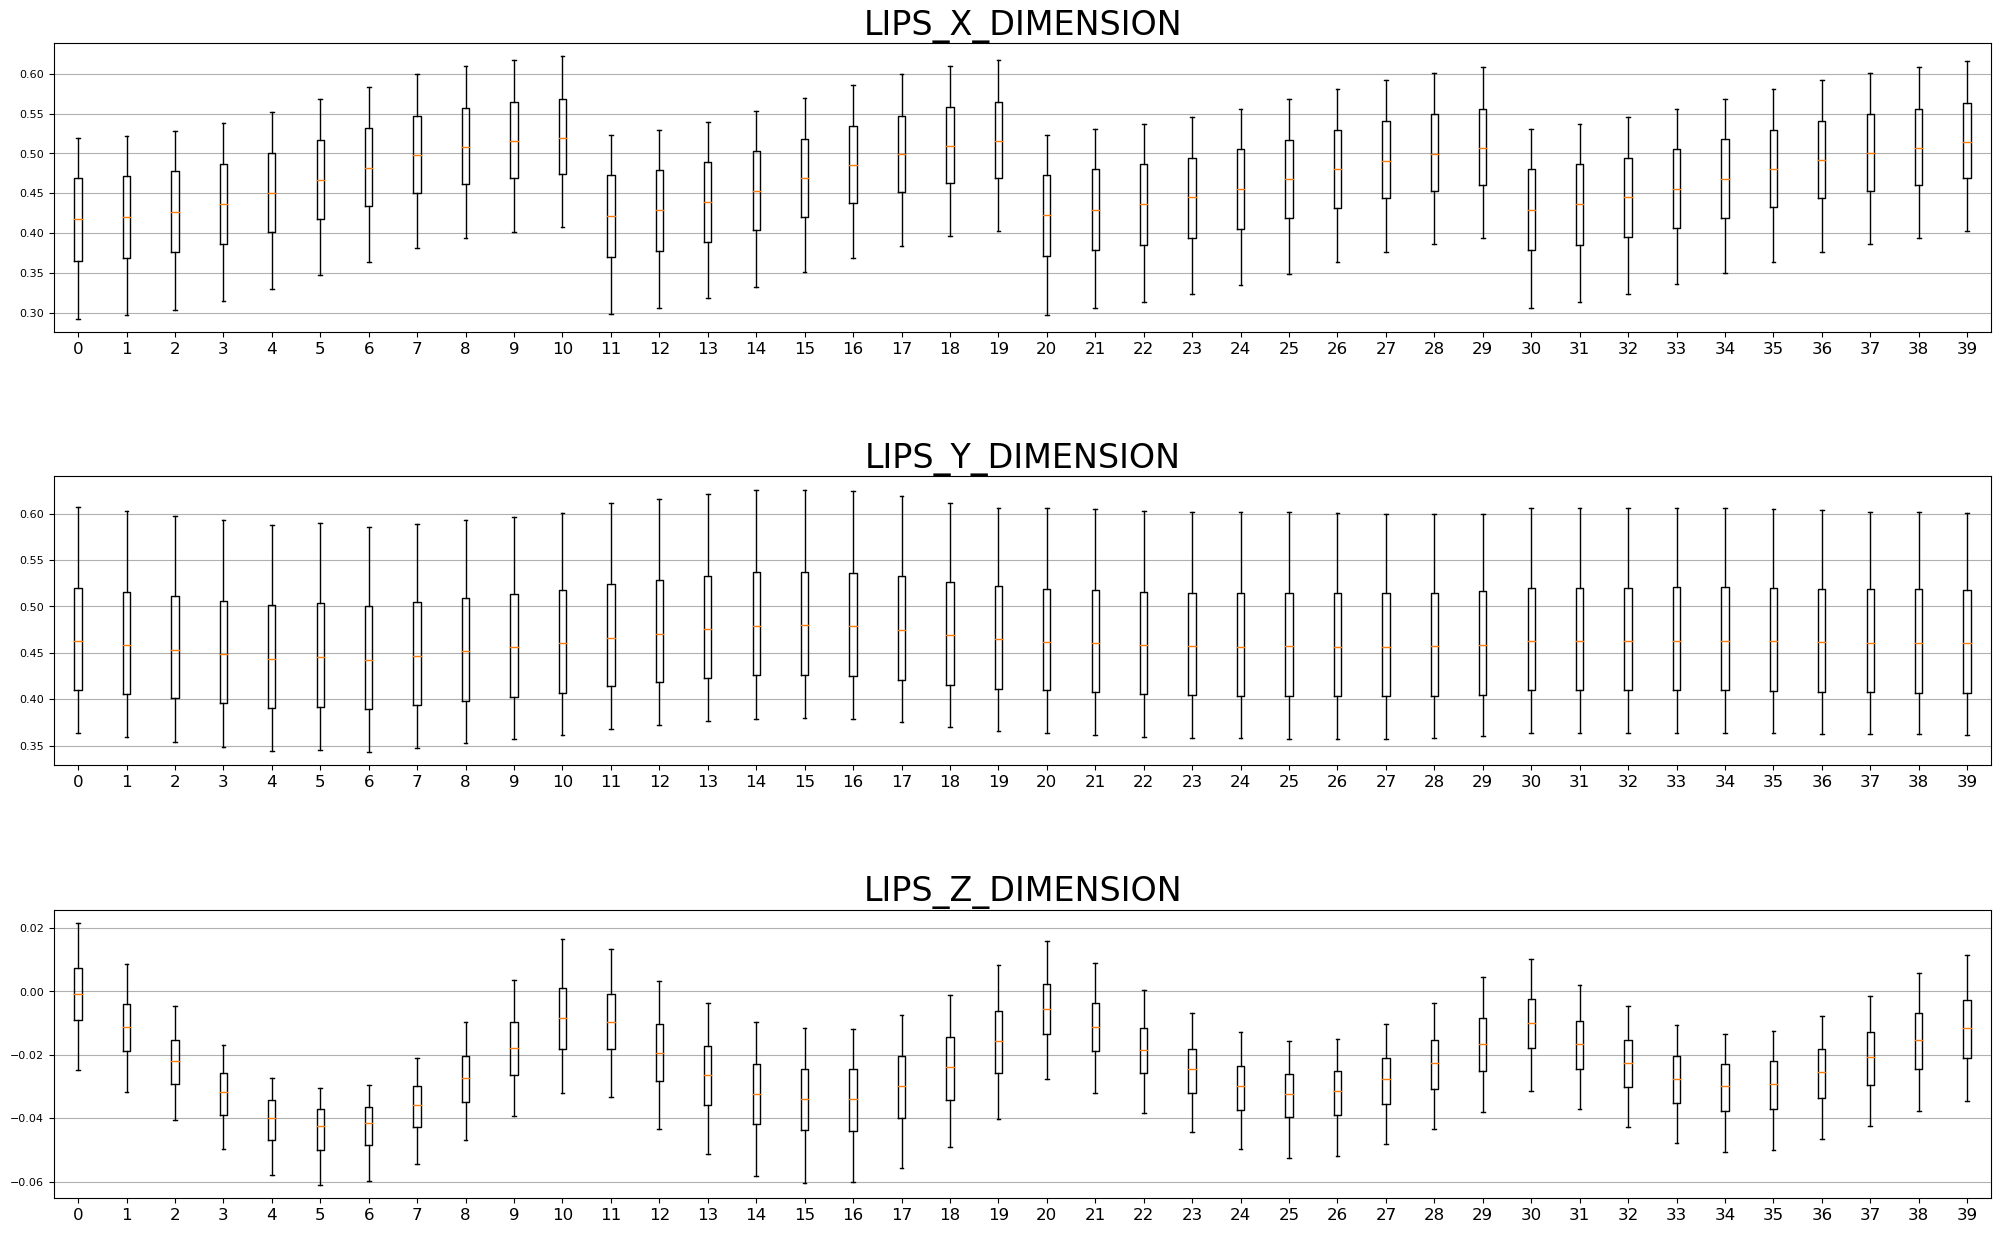

In [33]:
def get_mean_std(INDICES , feature):
    MEAN_X = np.zeros([INDICES.size])
    MEAN_Y = np.zeros([INDICES.size])
    STD_X = np.zeros([INDICES.size])
    STD_Y = np.zeros([INDICES.size])
    
    fig , axes = plt.subplots(3 , 1 , figsize = (25,15))
    
    for i , ll in enumerate(np.transpose(X_TRAIN[:,:,INDICES],[2,3,0,1]).reshape(INDICES.size , N_DIMS , -1)):
        for dim , v in enumerate(ll):
            v = v[np.nonzero(v)]
            if(dim == 0):
                MEAN_X[i] = v.mean()
                STD_X[i] = v.std()
            elif(dim == 1):
                MEAN_Y[i] = v.mean()
                STD_Y[i] = v.std()
                
            axes[dim].boxplot(v , notch = False , showfliers = False , positions = [i] , whis = [5,95])
        
    for ax , dim_name in zip(axes , DIM_NAMES):
        ax.set_title(f'{feature}_{dim_name.upper()}_DIMENSION',size = 24)
        ax.tick_params(axis = 'x',labelsize = 12)
        ax.grid(axis = 'y')
        
    plt.subplots_adjust(hspace=0.50)
    plt.show()
                
    MEAN_ARRAY = np.array([MEAN_X , MEAN_Y]).T 
    STD_ARRAY = np.array([STD_X , STD_Y]).T 
    
    return MEAN_ARRAY , STD_ARRAY 
    
LIPS_MEAN_ARRAY , LIPS_STD_ARRAY = get_mean_std(LIPS_IND , 'LIPS')

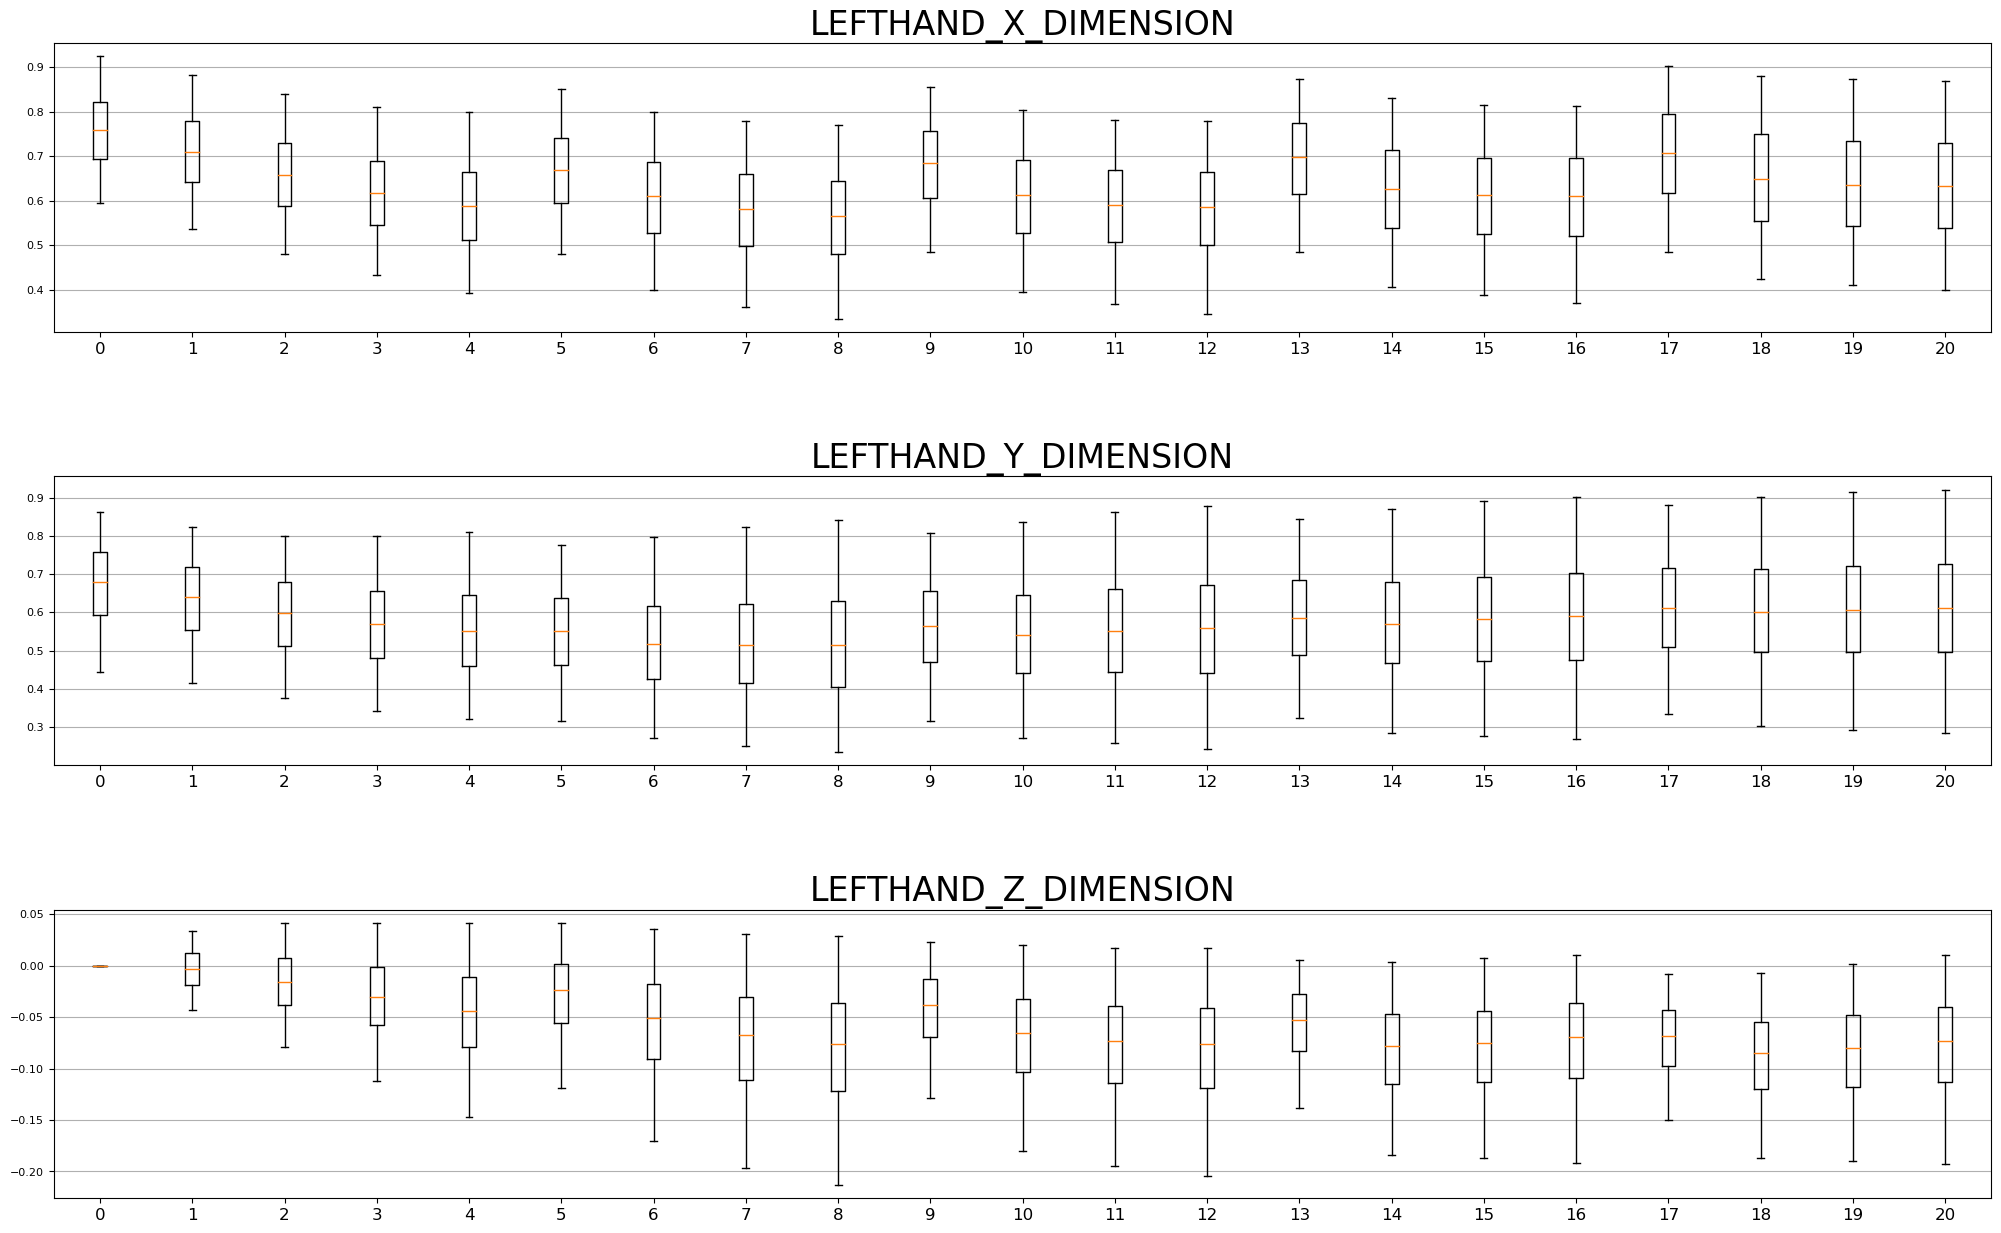

In [34]:
LEFTHAND_MEAN_ARRAY ,LEFTHAND_STD_ARRAY = get_mean_std(LEFTHAND_IND , 'LEFTHAND') 

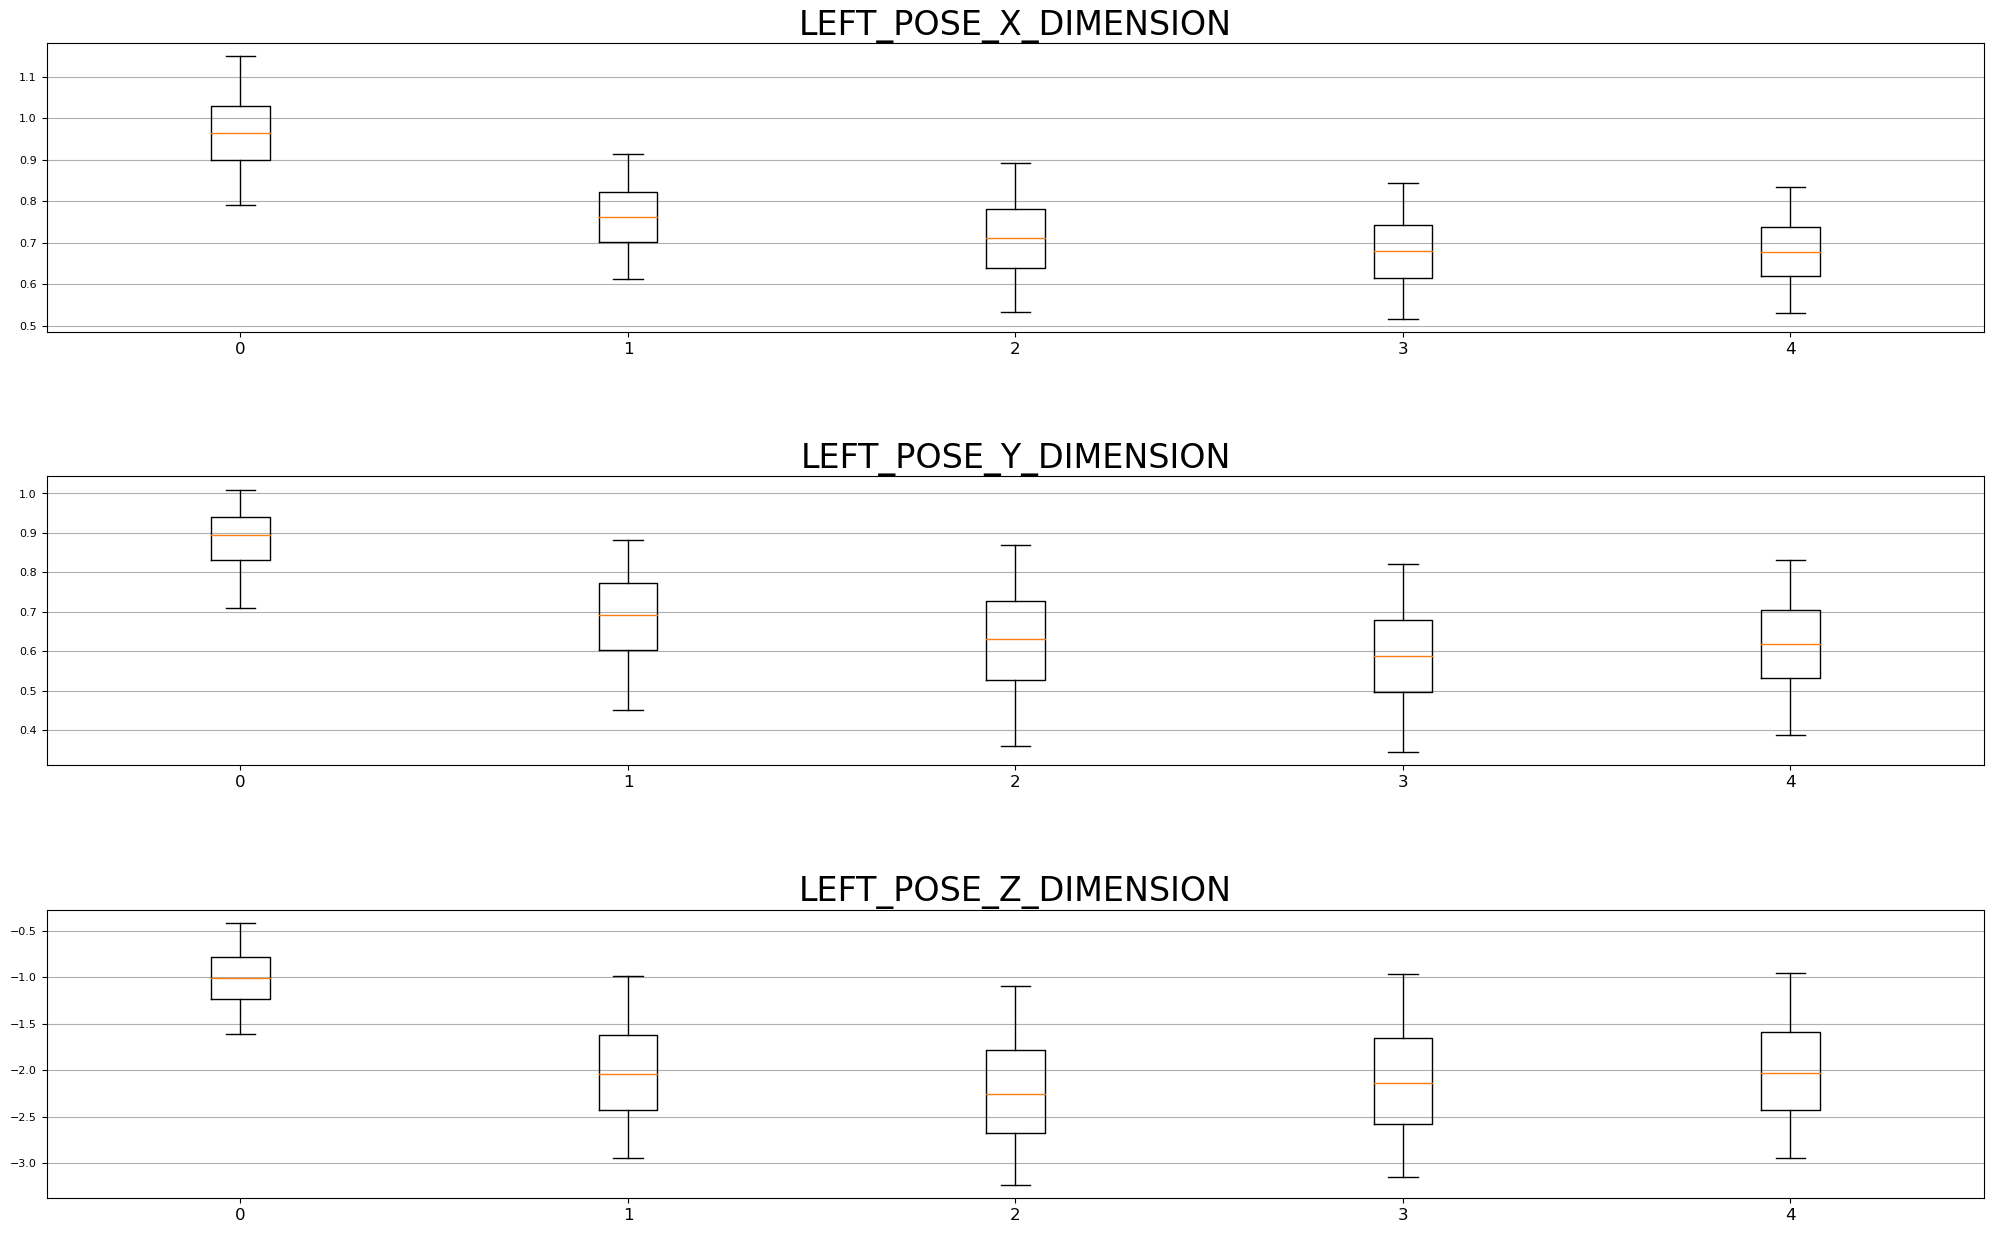

In [35]:
LEFTHAND_POSE_MEAN_ARRAY , LEFTHAND_POSE_STD_ARRAY = get_mean_std(LEFTHAND_POSE_IND , 'LEFT_POSE')